<a href="https://colab.research.google.com/github/murilo-henrique060/matematica-computacional/blob/main/Avalia%C3%A7%C3%A3o%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
from itertools import zip_longest

# Busca de Raízes com o método da bisseção

Encontrar raízes de funções reais é uma técnica muito utilizada no meio da programação. Essa técnica é separada em 2 partes:
- Isolamento das raízes: Determinar intervalos que contenham uma raiz;
- Refinamento: Utilização de um algoritmo, como a bisseção, para determinar um valor aproximado para a raiz de cada intervalo encontrado.

Vamos utilizar de exemplo a função:
$$
f(x) = x^3 - 9x + 3
$$

## Isolamento de raízes

Para realizar o isolamento de raízes, podemos utilizar o Teorema do Valor Intermediário, que diz que, para uma função contínua $f(x)$ em um intervalo fechado $[a, b]$, se temos um valor $k$ entre $f(a)$ e $f(b)$, então temos, pelo menos, um ponto $c$ tal que $f(c)$ = k.

Baseado no teorema, podemos buscar intervalos $[a, b]$, tal que $f(a) > 0$ e $f(b) < 0$, ou que $f(a) < 0$ e $f(b) > 0$, ou seja, $f(a)$ e $f(b)$ devem ter sinais opostos.

Para simplificar a definição, podemos buscar pontos $a$ e $b$ tal que $f(a) \cdot f(b) < 0$.

### Método Iterativo

Para isolar as raízes, podemos definir um intervalo de busca e um passo, assim podemos separar o intervalo em seções para realizar a busca dos intervalos

In [39]:
def root_isolation_basic(f, start=-10, end=10, sections=4, verbose=False):
  """
  Search for intervals that have at least a root in it
  """
  intervals = []

  # Defining the points inside the interval
  points = np.linspace(start, end, sections)

  # Iterating each interval (each 2 adjacent points define an interval)
  for a, b in zip(points, points[1:]):
    if verbose:
      print(f"x: {a:>5.1f}  f(x): {'-' if f(a) < 0 else '+'}")

    # If the signal of f(a) and f(b) are different there is, at least, one root inside the interval
    if f(a) * f(b) <= 0:
      intervals.append((float(a), float(b)))

  if verbose:
    print(f"x: {b:>5.1f}  f(x): {'-' if f(b) < 0 else '+'}")

  return intervals

f = lambda x: x**3 - 9 * x + 3 # x³ - 9x + 3
intervals = list(root_isolation_basic(f, verbose=True))

print()

print("Intervalos: " + " ".join(f"[{x}, {x1}]" for x, x1 in intervals))

x: -10.0  f(x): -
x:  -3.3  f(x): -
x:   3.3  f(x): +
x:  10.0  f(x): +

Intervalos: [-3.333333333333333, 3.333333333333334]


### Checagem de raízes

Para verificar se o intervalo contém apenas uma única raiz, podemos checar o sinal da derivada ao longo do intervalo, caso seja constante, confirmamos que há apenas uma derivada neste intervalo.

Para o exemplo apresentado teremos a derivada como:
$$
f'(x) = 3x^2 - 9
$$


In [40]:
def check_unique_root(d, a, b, samples=10):
  """
  Function that checks if there is only a single root inside the interval
  """

  # Defining the points interval
  points = np.linspace(a, b, samples)

  # Calculating the derivative of the first point
  d_a = d(a)

  # Iterating the points
  for x in points:
    # If the signal of the derivative changes in any point, so the interval can have more than 1 root on the interval
    if (d_a * d(x) < 0):
      return False

  return True

d = lambda x: 3 * x**2 - 9 # 3x² - 9
intervals = list(root_isolation_basic(f))
print()

print("Intervalos: " + " ".join(f"[{x}, {x1}]" for x, x1 in intervals))

print()
for a, b in intervals:
  print(f"[{a}, {b}] -> {'Tem raiz única' if check_unique_root(d, a, b) else 'Contém mais de uma raiz'}")


Intervalos: [-3.333333333333333, 3.333333333333334]

[-3.333333333333333, 3.333333333333334] -> Contém mais de uma raiz


Então, no caso do intervalo conter mais de uma raiz, podemos realizar uma busca mais refinada para encontrar raízes únicas.

In [41]:
def root_isolation(f, d, start=-10, end=10, samples=4):
  """
  Return all the single root subintervals inside the interval passed
  """
  intervals = []

  # Get all intervals that have 1 or more roots in it
  possible_intervals = root_isolation_basic(f, start, end, samples)

  # Iterating the intervals
  for a, b in possible_intervals:
    # If the interval has only one root, add it to the result
    if check_unique_root(d, a, b):
      intervals.append((a, b))

    # If not, compute all the single root subintervals inside the interval
    else:
      intervals.extend(root_isolation(f, d, a, b))

  return intervals

intervals = root_isolation(f, d)
print()

print("Intervalos: " + " ".join(f"[{x}, {x1}]" for x, x1 in intervals))


Intervalos: [-3.333333333333333, -2.592592592592592] [-1.1111111111111107, 1.1111111111111116] [2.5925925925925934, 3.333333333333334]


## Refinamento das Raízes

Para refinar as raízes utilizaremos o método da bisseção, no qual iniciamos com o intervalo $[a, b]$, e encontramos o ponto médio $x = \frac{(a + b)}{2}$, e verificamos se $f(x) * f(a) >= 0$, caso seja, $a$ recebe o valor de $x$, caso não, $b$ recebe o valor de $x$. Repetimos esse processo até que $b - a < ϵ$, para um $ϵ$ definido.

In [42]:
def bissect(function, a, b, e=10**-3, verbose=True):
  """
  Returns a aproximation of the root location inside the interval where one side result is greater than 0 and the other one is smaller
  """
  f_a = function(a)

  if verbose:
    print(f"| Iteration |     a     |     b     |   b - a   |     x     |    f(x)   |")

  i = 0
  # The computation stops when the distante of the 2 points is smaller than the e defined
  while b - a > e:
    # Calculating the middle point
    x = (a + b) / 2
    # Computing the f(x) value
    f_x = function(x)

    if verbose:
      print(f"| {i:^9} | {a:>9.5f} | {b:>9.5f} | {b-a:>9.5f} | {x:>9.5f} | {f_x:>9.5f} |")

    # If the signal of f(x) is the same as f(a), so update the value of a to x
    if f_a * f_x >= 0:
      a = x
      f_a = f_x

    # If not, update the value of b to x
    else:
      b = x

    i += 1

  if verbose:
      print(f"| {i:^9} | {a:>9.5f} | {b:>9.5f} | {b-a:>9.5f} | {x:>9.5f} | {f_x:>9.5f} |\n")

  return x

roots = [bissect(f, a, b) for a, b in root_isolation(f, d)]
print("Raízes:", roots)

| Iteration |     a     |     b     |   b - a   |     x     |    f(x)   |
|     0     |  -3.33333 |  -2.59259 |   0.74074 |  -2.96296 |   3.65437 |
|     1     |  -3.33333 |  -2.96296 |   0.37037 |  -3.14815 |   0.13255 |
|     2     |  -3.33333 |  -3.14815 |   0.18519 |  -3.24074 |  -1.86889 |
|     3     |  -3.24074 |  -3.14815 |   0.09259 |  -3.19444 |  -0.84763 |
|     4     |  -3.19444 |  -3.14815 |   0.04630 |  -3.17130 |  -0.35244 |
|     5     |  -3.17130 |  -3.14815 |   0.02315 |  -3.15972 |  -0.10868 |
|     6     |  -3.15972 |  -3.14815 |   0.01157 |  -3.15394 |   0.01225 |
|     7     |  -3.15972 |  -3.15394 |   0.00579 |  -3.15683 |  -0.04813 |
|     8     |  -3.15683 |  -3.15394 |   0.00289 |  -3.15538 |  -0.01792 |
|     9     |  -3.15538 |  -3.15394 |   0.00145 |  -3.15466 |  -0.00283 |
|    10     |  -3.15466 |  -3.15394 |   0.00072 |  -3.15466 |  -0.00283 |

| Iteration |     a     |     b     |   b - a   |     x     |    f(x)   |
|     0     |  -1.11111 |   1.11111 |

# Representação de Pontos Fluantes de Precisão Simples

A representação de números com partes fracionárias é um desafio para computadores, já que sua representação mais simples, Ponto Fixo, limita altamente a precisão dos números armazenados, por isso, a representação de números fracionários com pontos flutuantes é utilizada.

A representação de pontos flutuantes tem como base as expressões:

Números normalizados:
$$
x = (-1)^{\text{sinal}} \cdot (1 + \text{mantissa}) ̇\cdot 2^{\text{expoente}}$$

Números desnormalizados:
$$
x = (-1)^{\text{sinal}} \cdot (0 + \text{mantissa}) ̇\cdot 2^{\text{expoente}}$$

Onde:
- Sinal: representa o sinal no número, 0 para números positivos e 1 para números negativos;
- Mantissa: é a parte significativa do número, um número maior ou igual que 0 e menor que 1;
- Expoente: guarda a escala do número representado.

### IEEE 754
O padrão de representação que será utilizado será o IEEE 754, para representação de Ponto Flutante de Precisão Simples.

Esse padrão define o número de bits para cada parâmetro e a posição na qual será armazenada:
- Sinal: 1 bit;
- Expoente + Bias: 8 bits;
- Mantissa: 23 bits;

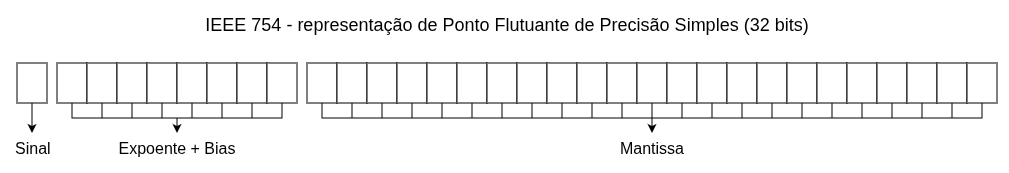

#### Bias
O expoente pode aceitar valores negativos, mas para armazená-lo precisamos convertê-lo para o intervalo 0-255, para isso, somamos o valor 127 ao expoente armazenado, e ao recuperá-lo subtraímos 127 para obter o seu valor real.

Expoente: -2
Expoente Armazenado: -2 + 127 = -125

#### Representações

O padrão IEEE 754 também define a representação de outros tipos de números: Infinito e Not a Number.

|Tipo|Condição|
|----|------|
|Normalizado| Expoente maior que 0 |
|Desnormalizado| Expoente igual a 0 e mantissa maior que 0|
| +-Infinito | Expoente igual a 255 e mantissa igual a 0 |
| NaN | Expoente igual a 255 e mantissa maior que 0 |

In [43]:
class Binary():
  """
  Class that defines basic operations with binary values

  - Creation: Binary("101")
  - Comparation: ==
  - Not: ~
  - And: &
  - Or: |
  - Add: +
  - Subtract: -
  - Left Shift: <<
  - Right Shift: >>
  """
  def __init__(self, value, length=None):
    value = "".join(value)
    self.__length = length if length is not None else len(value)
    self.__value = value.rjust(self.__length, '0')

  def __str__(self):
    return self.__value

  def __iter__(self):
    return iter(self.__value)

  def __len__(self):
    return self.__length


  @staticmethod
  def align(binary_0, binary_1):
    length = max(len(binary_0), len(binary_1))
    return Binary(binary_0, length), Binary(binary_1, length)


  def __eq__(self, other):
    binary_0, binary_1 = Binary.align(self, other)
    return binary_0.__value == binary_1.__value


  @staticmethod
  def __bit_not(bit):
    return '0' if bit == '1' else '1'

  def __invert__(self):
    return Binary(map(Binary.__bit_not, self))


  @staticmethod
  def __bit_and(bit_0, bit_1):
    return '1' if bit_0 == '1' and bit_1 == '1' else '0'

  def __and__(self, other):
    return Binary(map(Binary.__bit_and, *Binary.align(self, other)))


  @staticmethod
  def __bit_or(bit_0, bit_1):
    return '1' if bit_0 == '1' or bit_1 == '1' else '0'

  def __or__(self, other):
    return Binary(map(Binary.__bit_or, *Binary.align(self, other)))


  def __xor__(self, other):
    return (self & ~other) | (~self & other)


  @staticmethod
  def __single_lshift(binary):
    return Binary(binary.__value[1:] + '0')

  @staticmethod
  def __single_rshift(binary):
    return Binary('0' + binary.__value[:-1])


  def __add__(self, other):
    a, b = Binary.align(self, other)

    while b != "0":
      borrow = a & b
      a = a ^ b
      b = Binary.__single_lshift(borrow)

    return a

  def __sub__(self, other):
    a, b = Binary.align(self, other)

    while b != "0":
      borrow = ~a & b
      a = a ^ b
      b = Binary.__single_lshift(borrow)

    return a


  def __lshift__(self, places):
    result = self

    if isinstance(places, int):
      while places:
        result = Binary.__single_lshift(result)
        places -= 1
    else:
      places = Binary(places)
      while places != '0':
        result = Binary.__single_lshift(result)
        places -= '1'

    return result

  def __rshift__(self, places):
    places = Binary(places)
    result = self

    while places != '0':
      result = Binary.__single_rshift(result)
      places -= '1'

    return result

In [46]:
def float_to_fixed(bits):
  """
  Converts a IEEE 754 Single Precision Float Point number to a Fixed Point Binary Number
  """

  print(f"\nConvertendo {bits}\n")

  signal = Binary(bits[0])           # First bit, represents the signal of the result number, 0 for positive and 1 for negative
  biased_expoent = Binary(bits[1:9]) # 8 bits after signal, represent the expoent or 'scale' of the number
  mantissa = Binary(bits[9:])        # Last 23 bits, represents the mantissa or the significant part of the number

  expoent = biased_expoent - "01111111" # Converting the biased expoent to the real expoent value

  print(f"Sinal = {signal}")
  print(f"Expoente + Bias = {biased_expoent}")
  print("Bias = 1111111")
  print(f"Expoente = {expoent}")
  print(f"Mantissa = {mantissa}\n")

  signal_simbol = "+" if signal == "0" else "-" # Positive if signal equals to 0, negative otherwise

  # If the expoent has a value of 255, one of two special cases can happen
  if (biased_expoent == "11111111"):
    # If mantissa is equals to 0, the number represented is +-Infinity, depending of the signal value
    if (mantissa == "0"):
      print("Como expoente igual a 255 e mantissa igual a 0, o número representado é +-Infinito\n")
      return signal_simbol + "Infinity"
    # If not, the value represented is NaN
    else:
      print("Como expoente igual a 255 e mantissa diferente de 0, NaN é representado\n")
      return "NaN"

  # If expoents value is equals 0, the number is represented as a denormalized number (0.mantissa) instead of the normalized form (1.mantissa)
  implicit_bit = "0" if biased_expoent == "0" else "1"

  print(f"Bit implícito = {implicit_bit}\n")

  print(f"resultado = (-1)^{signal} * ({implicit_bit} + 0.{mantissa}) * 2^({expoent})")

  # Calculating the significant part as a fixed point number (implicit_bit.mantissa)
  # We need to rezise the implicit bit number to support the 23 bit mantissa number, so the new length is 24 (1 implicit bit + 23 mantissa bits)
  # We also need to bit shift the implicit bit to the front, so we will be able to insert the mantissa value after it, so we left shift 23 times (mantissa's size)
  # To insert the mantissa at the end of implicit bit we are gonna sum both values, getting a number with one integer place and 23 fractional places
  significant = (Binary(implicit_bit, 24) << 23) + mantissa

  # Multiplying the significant by 2^expoent value
  # To multiply by 2^n in binary we can do a left shift n times, and for multiply by 2^(-n) (or dividing by 2^n) we can do a right shift n times
  # We need to enlarge the output bit to support the largest and smallest values to be represented by single precision float points
  # The output number has 278 bits, 151 for the integer portion and 127 for the fractional one
  # To reduce code complexity, instead of starting the number at center position and shifiting it left or right depending on the value of n
  # We can make the value of n aways positive, by using the biased expoent, and starting with the significant at the rightmost position, shifting it only to the left
  output = Binary(significant, 278) << biased_expoent

  output_str = str(output)

  # The fixed point is located at the 150 position from right to left at the number, 127 been from the max possible right shifts and 23 from the already fractional mantissa
  integer_part = output_str[:-150].lstrip('0') # Separating the integer part and removing excessive left 0s
  fractional_part = output_str[-150:].rstrip('0') # Separating the fractional part and removing excessive right 0s

  result = f"{signal_simbol}{integer_part:>01}.{fractional_part:<01}"
  print(f"Resultado em Binário = {result}\n")

  return result

In [44]:
float_to_fixed("00111110010100000000000000000000")


Convertendo 00111110010100000000000000000000

Sinal = 0
Expoente + Bias = 01111100
Bias = 1111111
Expoente = 11111101
Mantissa = 10100000000000000000000

Bit implícito = 1

resultado = (-1)^0 * (1 + 0.10100000000000000000000) * 2^(11111101)
Resultado em Binário = +0.001101



'+0.001101'

In [45]:
float_to_fixed("01000001011100000000000000000000")


Convertendo 01000001011100000000000000000000

Sinal = 0
Expoente + Bias = 10000010
Bias = 1111111
Expoente = 00000011
Mantissa = 11100000000000000000000

Bit implícito = 1

resultado = (-1)^0 * (1 + 0.11100000000000000000000) * 2^(00000011)
Resultado em Binário = +1111.0



'+1111.0'

## Conversão de Binário de ponto fixo para decimal

Agora que convertemos o número de ponto fluante para ponto fixo, podemos convertê-lo para sua versão decimal. Para isso, podemos analizar o número binário como uma sequência de somas:

Exemplo:
$$
1100 = 1 \cdot 2^3 + 1 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0 = 12
$$

Essa análise se extende para a parte decimal:
$$
100.011 = 1 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0 + 0 \cdot 2^{-1} + 1 \cdot 2^{-2} + 1 \cdot 2^{-3} = 4.375
$$


In [47]:
def fixed_point_binary_to_decimal(bits):
  """
  Converts a fixed point binary to it's decimal representation
  """

  # The first bit represents the signal of the number, the '+' (0) make the number positive, and the '-' (1) make the number negative
  signal = (-1)**(0 if bits[0] == '+' else 1)

  # The fixed point binary fractional separator is '.' inside the bit array
  if "." in bits:
    integer_part, fractional_part = bits[1:].split(".")
  # The ausence of the separator represents that the whole number is integer
  else:
    integer_part, fractional_part = bits[1:], ""

  # If we represent the number in the format
  # D = b_n * 2^n + ... + b_1 * 2^1 + b_0 ** 2^0 + b_-1 * 2^-1 + ... + b_-m * 2^-m
  # We can separate the value in two sequences, one for the integer part and one for the fractional part

  integer_value = sum(int(bit) * 2**power for power, bit in enumerate(reversed(integer_part)))          # b_0 * 2^0 + b_1 * 2^1 + b_2 * 2^2 + ...
  fractional_value = sum(int(bit) * 2**(-power) for power, bit in enumerate(fractional_part, start=1))  # b_-1 * 2^-1 + b_-2 * 2^-2 + b_-3 * 2^-3 + ...

  return signal * (integer_value + fractional_value)

In [48]:
fixed_point_binary_0 = float_to_fixed("00111110010100000000000000000000")
decimal_0 = fixed_point_binary_to_decimal(fixed_point_binary_0)
print(f"Resultado decimal: {decimal_0}\n")


Convertendo 00111110010100000000000000000000

Sinal = 0
Expoente + Bias = 01111100
Bias = 1111111
Expoente = 11111101
Mantissa = 10100000000000000000000

Bit implícito = 1

resultado = (-1)^0 * (1 + 0.10100000000000000000000) * 2^(11111101)
Resultado em Binário = +0.001101

Resultado decimal: 0.203125



In [49]:
fixed_point_binary_1 = float_to_fixed("01000001011100000000000000000000")
decimal_1 = fixed_point_binary_to_decimal(fixed_point_binary_1)
print(f"Resultado decimal: {decimal_1}\n")


Convertendo 01000001011100000000000000000000

Sinal = 0
Expoente + Bias = 10000010
Bias = 1111111
Expoente = 00000011
Mantissa = 11100000000000000000000

Bit implícito = 1

resultado = (-1)^0 * (1 + 0.11100000000000000000000) * 2^(00000011)
Resultado em Binário = +1111.0

Resultado decimal: 15.0

